<a href="https://colab.research.google.com/github/bryandaetz1/Data_Viz_Assignments/blob/main/SB_County_COVID_Cases_by_Area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

# Scraping Data

In [224]:
#specify URL/web page to scrape
url = 'https://publichealthsbc.org/status-reports/'

#create user-agent (Windows 10 with Google Chrome)
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '\
'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.03987.149 '\
'Safara/537.36'

headers = {'User-Agent': user_agent}

In [225]:
response = requests.get(url, headers = headers).text

#parse HTML from web page into BeautifulSoup parse tree format
soup = BeautifulSoup(response, 'html.parser')

soup.title

<title>Status Reports – County of Santa Barbara</title>

In [226]:
#date data was posted
dates = soup.find_all('a',{'class':'elementor-accordion-title'}) 

In [227]:
#getting the element for each historical date where covid data was posted
items = soup.find_all('div',{'class':'elementor-accordion-item'})

In [228]:
#iterating through available data for each date
master_list = []    #master list with all cases by area data for each date
date_list = []      #list to store dates where data is available
index = -1
while dates[index + 1].text.strip() != 'June 24, 2020 as of 4:00 p.m.':  #table format changed on June 24th, prior to then SB county wasn't tracking/publishing active case count
    index = index + 1  
    table = items[index].find_all('table')
    if table == []:    #some dates didn't have data available, including this condition to skip those dates
      continue
    else:
      date_list.append(dates[index].text.strip())
      rows = table[0].find_all('tr')
      table_list = []     #list of rows in table
      for row in rows:
        contents = row.find_all('td')
        row_list = []   #list of data in each row
        for content in contents:
          row_list.append(content.text)
        table_list.append(row_list) 
      master_list.append(table_list)

# Converting to Dataframe and Cleaning Data

In [229]:
#creating dataframe from list of lists
columns = master_list[0][0]
df = pd.DataFrame(master_list[0][1:], columns = columns)    #creating initial dataframe with data for first date only. rows for each geographic area
df['Date'] = [date_list[0]] * len(df)     #creating date column

for i in range(len(master_list)):
  if i == 0:
    continue
  else:
    temp_df = pd.DataFrame(master_list[i][1:], columns = columns)     
    temp_df['Date'] = [date_list[i]] * len(temp_df)
    df = pd.concat([df, temp_df], axis = 0, sort = False) 

In [230]:
#resetting index
df.reset_index(drop = True, inplace = True)

In [231]:
df.dtypes

Geographic Area               object
Daily Cases                   object
Total  Confirmed Cases        object
Recovered by Region           object
Still infectious by Region    object
Number of Deaths              object
Date                          object
dtype: object

In [232]:
df.isna().sum()

Geographic Area               0
Daily Cases                   0
Total  Confirmed Cases        0
Recovered by Region           0
Still infectious by Region    0
Number of Deaths              0
Date                          0
dtype: int64

In [233]:
#creating new date column with just the date (no time) and converting to date/time format
df['Date_Clean'] = df['Date'].apply(lambda x: x.split('as')[0].strip() if 'as' in x       #getting only the date portion of the dates that also include a time
                                              else x)
#converting to date/time format
df['Date_Clean'] = pd.to_datetime(df['Date_Clean'])

In [234]:
df['Geographic Area'].value_counts()

SANTA YNEZ VALLEY including the Cities of Solvang & Buellton, and the communities of Santa Ynez, Los Alamos, Los Olivos and Ballard    76
CITY OF SANTA MARIA                                                                                                                    76
UNINCORPORATED AREAS of Sisquoc, Casmalia, Garey,  Cuyama, New Cuyama, and the City of Guadalupe                                       76
Pending                                                                                                                                76
SOUTH COUNTY UNINCORPORATED AREA includes communities of Montecito, Summerland and the City of Carpinteria                             76
COMMUNITY OF ISLA VISTA                                                                                                                76
CITY OF GOLETA                                                                                                                         76
COMMUNITY OF ORCUTT               

In [235]:
#cleaning up Geographic Area column
df['Area'] = df['Geographic Area'].replace(
                            {'SOUTH COUNTY UNINCORPORATED AREA includes communities of Montecito, Summerland and the City of Carpinteria':'South County Unincorporated Area',
                             'CITY OF SANTA BARBARA and the unincorporated area of Mission Canyon':'Santa Barbara',
                             'CITY OF GOLETA':'Goleta',
                             'COMMUNITY OF ISLA VISTA':'Isla Vista',
                             'UNINCORPORATED AREA OF THE GOLETA VALLEY AND GAVIOTA':'Goleta Valley/Gaviota',
                             'SANTA YNEZ VALLEY including the Cities of Solvang & Buellton, and the communities of Santa Ynez, Los Alamos, Los Olivos and Ballard':'Santa Ynez Valley',
                             'CITY OF LOMPOC and the communities of Mission Hills and Vandenberg Village':'Lompoc',
                             'FEDERAL PRISON IN LOMPOC':'Federal Prison in Lompoc',
                             'CITY OF SANTA MARIA':'Santa Maria',
                             'COMMUNITY OF ORCUTT':'Orcutt',
                             'UNINCORPORATED AREAS of Sisquoc, Casmalia, Garey,\xa0 Cuyama, New Cuyama, and the City of Guadalupe':'Other Unincorporated Areas',
                             'Total**':'Total',
                             'Total*':'Total'})
                               
df['Area'].value_counts()

Goleta                              76
Santa Maria                         76
Santa Ynez Valley                   76
South County Unincorporated Area    76
Pending                             76
Other Unincorporated Areas          76
Orcutt                              76
Lompoc                              76
Santa Barbara                       76
Isla Vista                          76
Federal Prison in Lompoc            76
Out of County                       76
Total                               76
Goleta Valley/Gaviota               76
Name: Area, dtype: int64

In [236]:
df.columns.to_list()

['Geographic Area',
 'Daily Cases',
 'Total\xa0 Confirmed Cases',
 'Recovered by Region',
 'Still infectious by Region',
 'Number of Deaths',
 'Date',
 'Date_Clean',
 'Area']

In [237]:
#converting columns that should be numeric to numeric
for col in ['Daily Cases','Total\xa0 Confirmed Cases','Recovered by Region','Still infectious by Region','Number of Deaths']:
  df[col] = df[col].apply(lambda x: x[:-1] if '*' in x else x)    #there are a few cases where the number was follwed by an asterisk, removing asterisks
  df[col] = df[col].str.strip().replace('—',np.nan)   #changing missing values to null so they don't appear on graph 
  df[col] = pd.to_numeric(df[col])     #converting to numeric

In [238]:
df.isna().sum()

Geographic Area                0
Daily Cases                   76
Total  Confirmed Cases        76
Recovered by Region           14
Still infectious by Region    14
Number of Deaths              88
Date                           0
Date_Clean                     0
Area                           0
dtype: int64

In [239]:
#dropping unneccesary columns
df_clean = df.drop(['Geographic Area', 'Date'], axis = 1)
df_clean.head()

,Daily Cases,Total Confirmed Cases,Recovered by Region,Still infectious by Region,Number of Deaths,Date_Clean,Area
0,0.0,202.0,193.0,2.0,7.0,2020-10-12,South County Unincorporated Area
1,3.0,1249.0,1227.0,9.0,13.0,2020-10-12,Santa Barbara
2,1.0,268.0,260.0,4.0,4.0,2020-10-12,Goleta
3,1.0,255.0,247.0,7.0,1.0,2020-10-12,Isla Vista
4,0.0,209.0,204.0,3.0,2.0,2020-10-12,Goleta Valley/Gaviota


# Visualizing Data
For now, I chose to focus on visualizing the number of active cases in each region over time, as this would be the most relavant information for those concerned about being exposed to the virus.

In [240]:
#for visualization purposes I don't want to include the totals and I'm only focusing on the Still infectious by Region and Date_Clean columns for now
df_viz = df_clean[['Still infectious by Region','Date_Clean','Area']][df_clean['Area'] != 'Total']

#dropping data from when number of active cases wasn't being tracked
df_viz.drop(df_viz[df_viz['Still infectious by Region'] == -1].index, axis = 0, inplace = True)

df_viz.head()

,Still infectious by Region,Date_Clean,Area
0,2.0,2020-10-12,South County Unincorporated Area
1,9.0,2020-10-12,Santa Barbara
2,4.0,2020-10-12,Goleta
3,7.0,2020-10-12,Isla Vista
4,3.0,2020-10-12,Goleta Valley/Gaviota


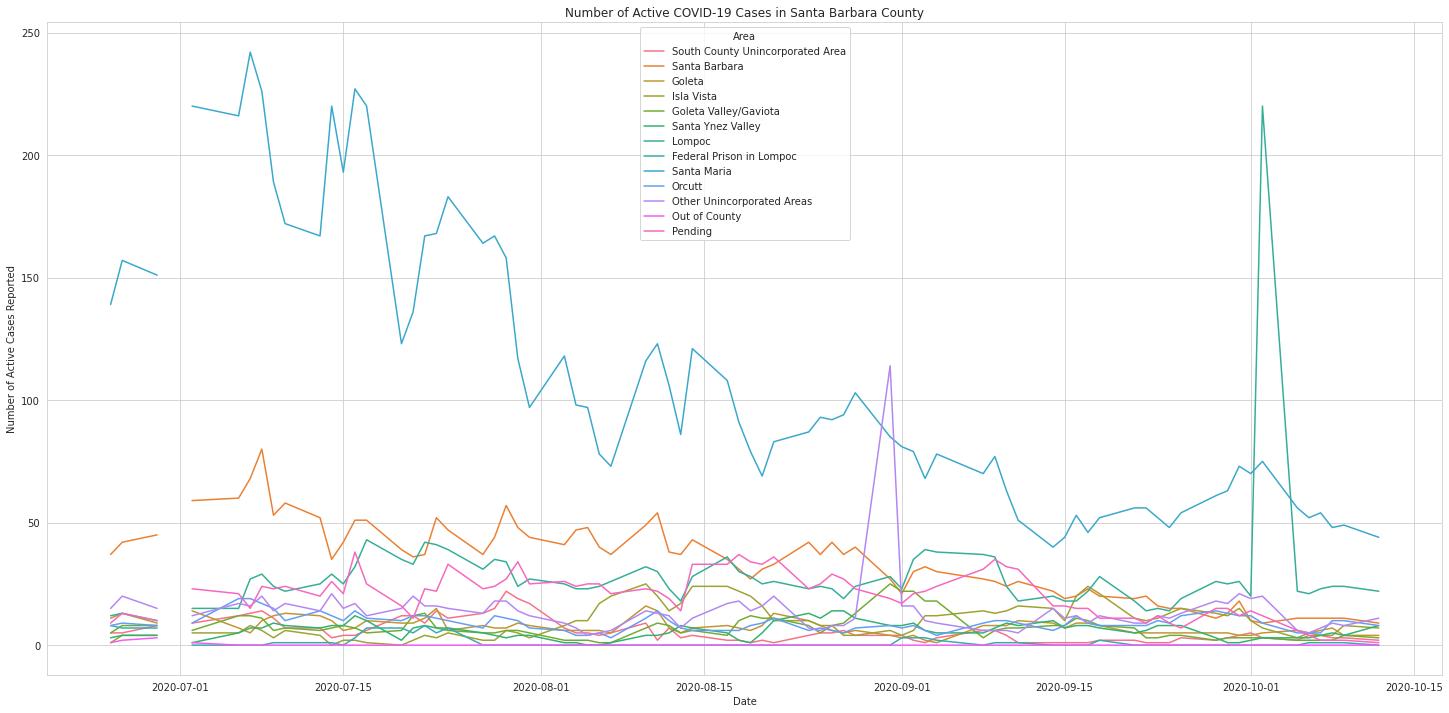

In [241]:
plt.figure(figsize=(25,12))
sns.set_style('whitegrid')

sns.lineplot(x = 'Date_Clean', 
             y = 'Still infectious by Region', 
             hue = 'Area', 
             data = df_viz)

plt.title('Number of Active COVID-19 Cases in Santa Barbara County')
plt.xlabel('Date')
plt.ylabel('Number of Active Cases Reported')
plt.show()

In [242]:
#examining null values, looks like all are from the same date
df_viz[df_viz['Still infectious by Region'].isna()]

,Still infectious by Region,Date_Clean,Area
1008,NaN,2020-07-01,South County Unincorporated Area
1009,NaN,2020-07-01,Santa Barbara
1010,NaN,2020-07-01,Goleta
1011,NaN,2020-07-01,Isla Vista
1012,NaN,2020-07-01,Goleta Valley/Gaviota
1013,NaN,2020-07-01,Santa Ynez Valley
1014,NaN,2020-07-01,Lompoc
1015,NaN,2020-07-01,Federal Prison in Lompoc
1016,NaN,2020-07-01,Santa Maria
1017,NaN,2020-07-01,Orcutt


In [243]:
#examining outlier for Lompoc
df_viz.loc[(df_viz['Area'] == 'Lompoc') & (df_viz['Date_Clean'] > '2020-10-01') & (df_viz['Date_Clean'] < '2020-10-15')]

,Still infectious by Region,Date_Clean,Area
6,22.0,2020-10-12,Lompoc
20,24.0,2020-10-09,Lompoc
34,24.0,2020-10-08,Lompoc
48,23.0,2020-10-07,Lompoc
62,21.0,2020-10-06,Lompoc
76,22.0,2020-10-05,Lompoc
90,220.0,2020-10-02,Lompoc


In [244]:
#dropping null values
df_viz.dropna(axis = 0, inplace = True)

#fixing outlier, looks like an extra zero was added by mistake
df_viz.loc[(df_viz['Area'] == 'Lompoc') & (df_viz['Still infectious by Region'] > 200), ['Still infectious by Region']] = 22.0
df_viz.loc[(df_viz['Area'] == 'Lompoc') & (df_viz['Still infectious by Region'] > 200), ['Still infectious by Region']] = 22.0


#limiting number of areas for readability
df_viz = df_viz[df_viz['Area'].isin(['Santa Barbara','Goleta','Isla Vista','Goleta Valley/Gaviota','Santa Ynez Valley','Lompoc','Orcutt'])].reset_index(drop = True)

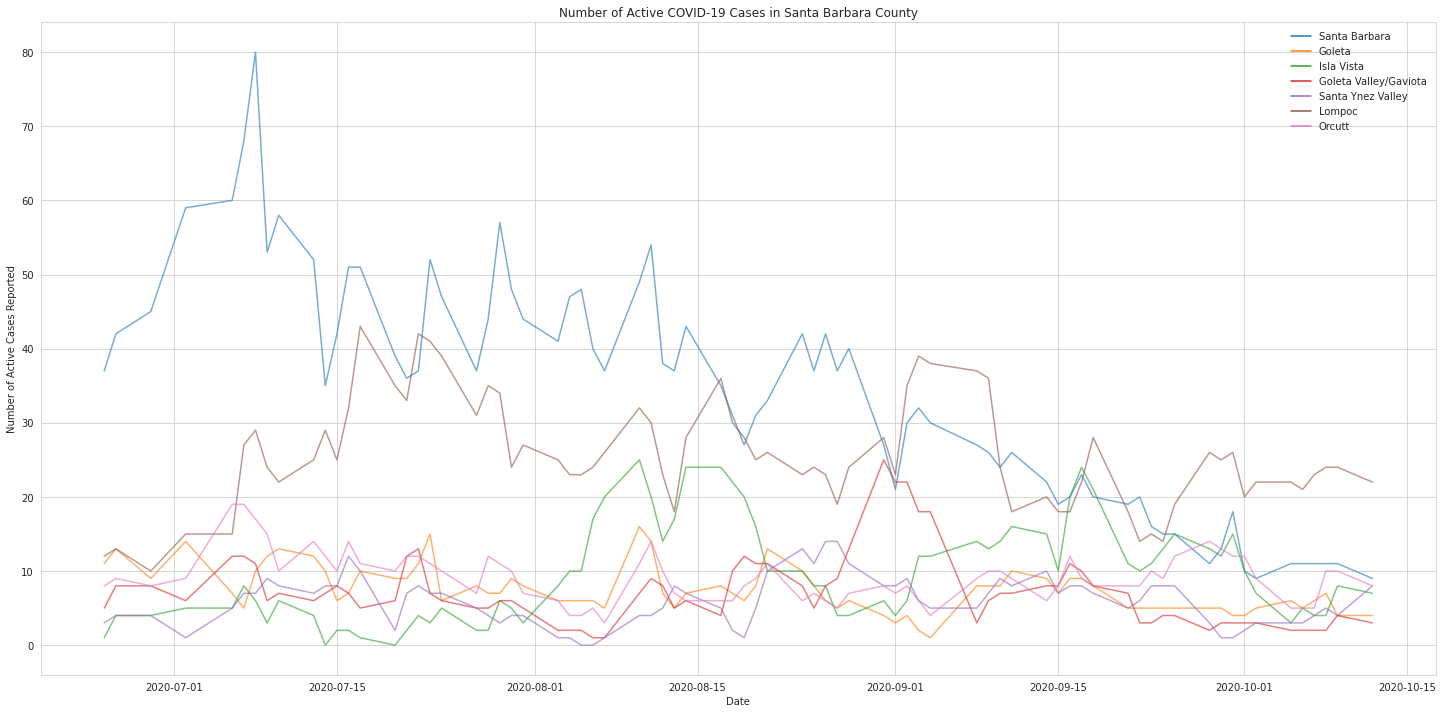

In [245]:
#plotting graph again
plt.figure(figsize=(25,12))
sns.set_style('whitegrid')

sns.lineplot(x = 'Date_Clean', 
             y = 'Still infectious by Region', 
             hue = 'Area', 
             alpha = 0.6, 
             data = df_viz)

plt.title('Number of Active COVID-19 Cases in Santa Barbara County')
plt.xlabel('Date')
plt.ylabel('Number of Active Cases Reported')
plt.legend(frameon = False)
plt.show()